In [1]:
from mynn import *
prefix = "../"
θ = np.load(prefix+"random_8_direct_theta.npy")   
κ = np.load(prefix+"random_8_direct_omega.npy")
        
θ_train, κ_train = θ[:, 0::2].transpose(), κ[:, :,  0::2]
θ_test, κ_test = θ[:, 1::2].transpose(), κ[:, :,  1::2]

# θ_test, κ_test = θ[0::2], κ[:, :,  0::2]

coeff_scale = 100.0
# θ_test, κ_test = θ[0::2], κ[:, :,  0::2]



data_svd, bases, N_trunc = build_bases(κ_train, acc=0.99)


x_train = torch.from_numpy(θ_train.astype(np.float32))
y_train = torch.from_numpy(data_svd.astype(np.float32)*coeff_scale)

N_trunc =  282


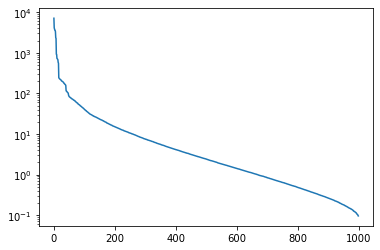

In [2]:
N_x, N_y, N_data = κ_train.shape
data = κ.reshape((-1, N_data))
# svd bases
u, s, vh = np.linalg.svd(np.transpose(data))

plt.semilogy(s)

In [3]:
N_θ = 8
model = DirectKernelRomNet(N_θ, N_trunc)

model = torch.load("DirectKernelRomNet.model")

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)


n_epochs = 0  #500000
for epoch in range(n_epochs):
    
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_train)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train) * 1000

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
        
    if epoch % 10000 == 0:
        print("[{}/{}], loss: {}".format(epoch, n_epochs, np.round(loss.item(), 3)))
        torch.save(model, "DirectKernelRomNet.model")

	
# save the model
torch.save(model, "DirectKernelRomNet.model")

/Users/huang/Src/anaconda3/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


## Training error 

Average error is  0.10082513169835454


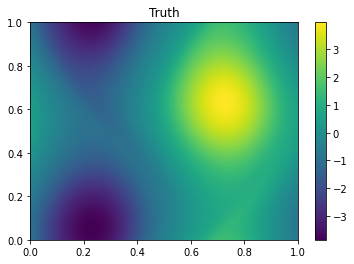

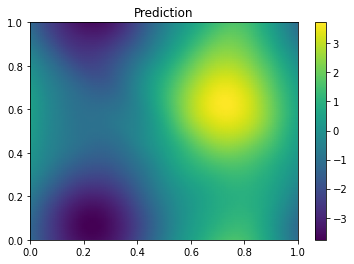

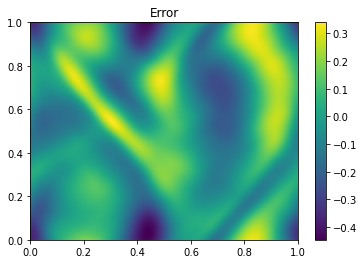

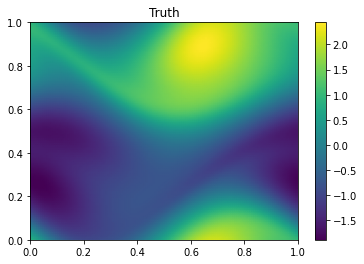

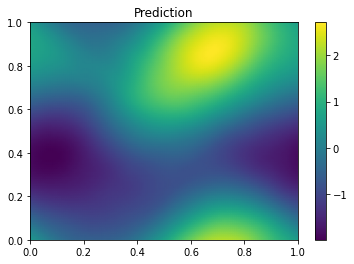

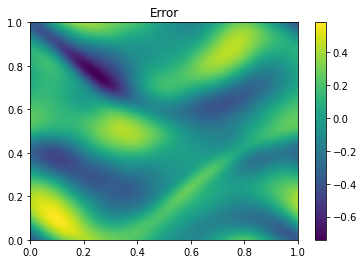

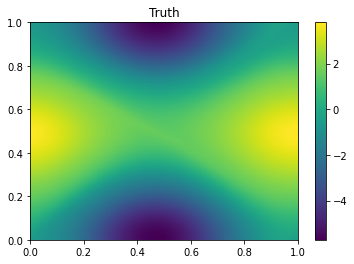

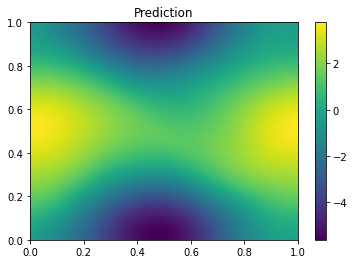

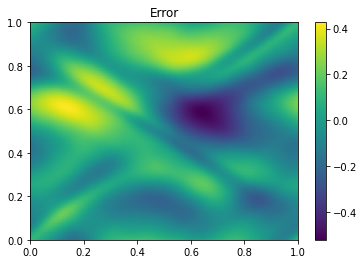

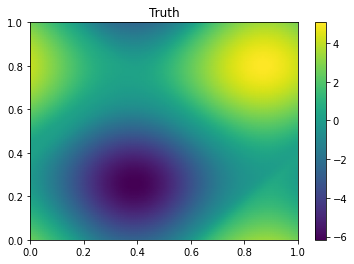

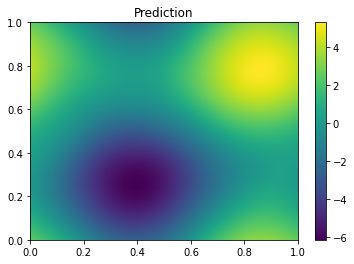

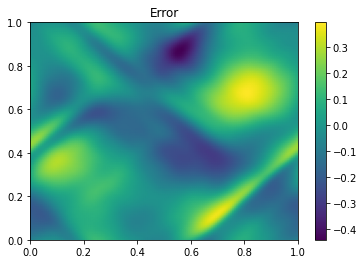

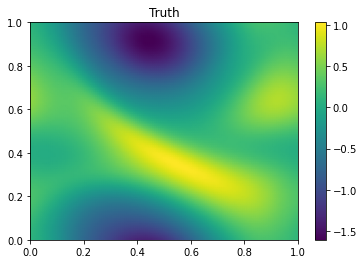

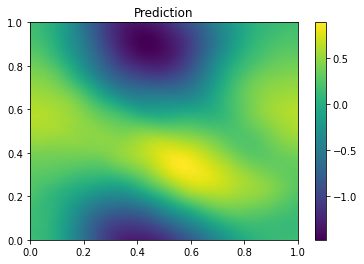

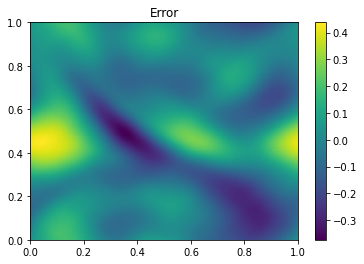

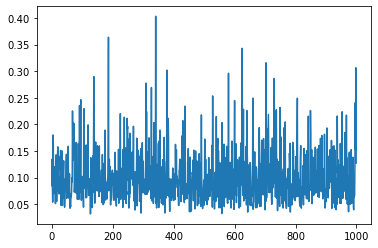

In [4]:
######################################################
N_θ = 8
N_data  =  θ_train.shape
N_x, N_y, N_data = κ_train.shape

L = 1.0
xx = np.linspace(0, L, N_x)
Y, X = np.meshgrid(xx, xx)

model = torch.load("DirectKernelRomNet.model")
κ_pred = model(torch.from_numpy(θ_train.astype(np.float32))).detach().numpy()
κs_pred = np.zeros((N_x, N_y, N_data))
for i in range(N_data):
    κs_pred[:,:,i] = np.dot(κ_pred[i, :]/coeff_scale  , bases).reshape(N_x, N_y)

train_ids = np.arange(0, N_data)
errors = np.zeros(len(train_ids))

for train_id in train_ids:

    errors[train_id] =  np.linalg.norm(κs_pred[:, :, train_id] - κ_train[:, :, train_id])/np.linalg.norm(κ_train[:, :, train_id])
    # print(prefix+"data %i, relative error is %.5f:" % (test_id, errors[test_id]))

    if train_id %249 == 0:
        # vmin, vmax = np.min(κ_test[:, :, test_id]), np.max(κ_test[:, :, test_id])
        
        vmin, vmax = None, None
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_train[:, :, train_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Truth")
        fig.savefig(prefix+"Truth_%04i.png" % train_id)

        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, train_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Prediction")
        fig.savefig(prefix+"Prediction_%04i.png" % train_id)
        
        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, train_id] - κ_train[:, :, train_id], shading="gouraud")
        plt.colorbar()
        plt.title("Error")
        
        

print("Average error is ", np.average(errors))
fig = plt.figure()
plt.plot(errors)



## Test error 

Average error is  0.22536186267984906


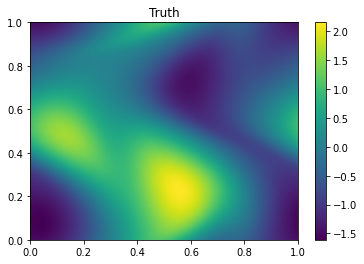

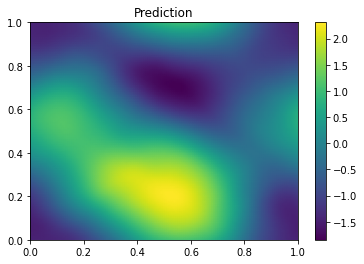

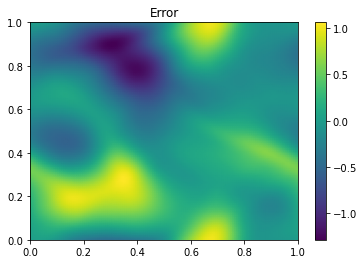

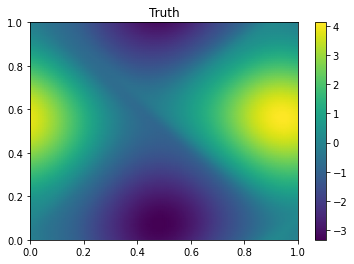

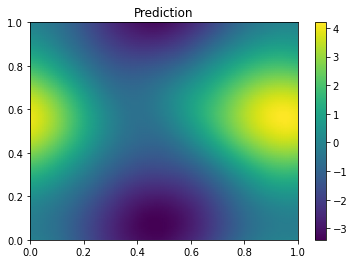

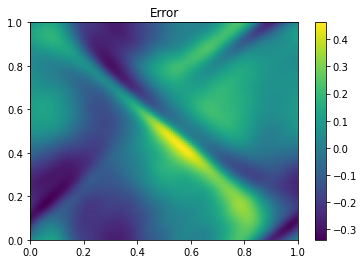

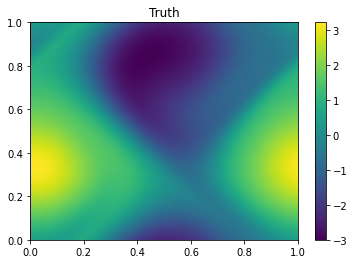

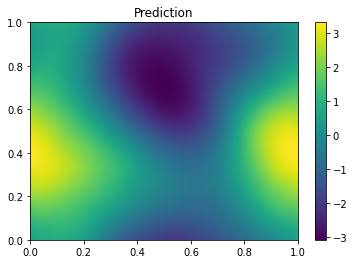

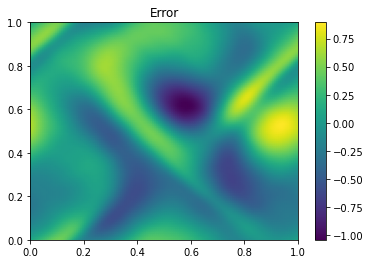

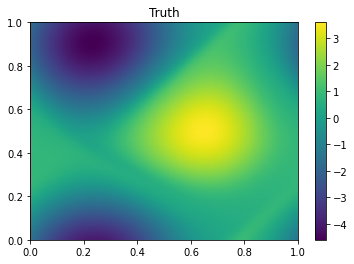

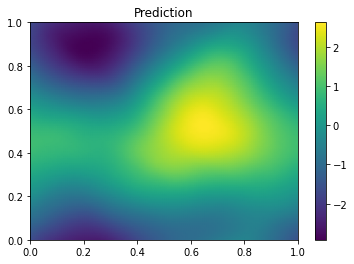

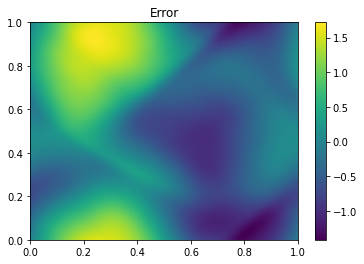

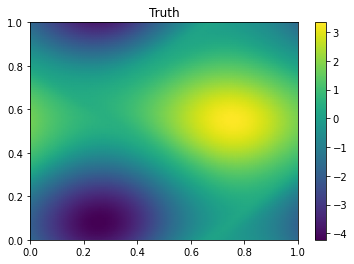

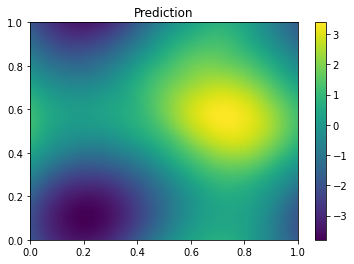

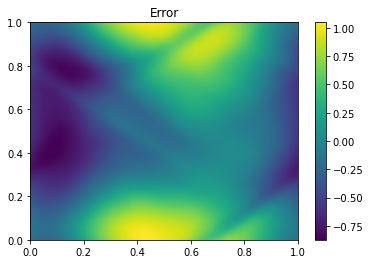

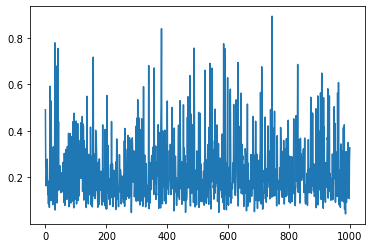

In [5]:
N_θ = 8
N_data  =  θ_test.shape
N_x, N_y, N_data = κ_test.shape

L = 1.0
xx = np.linspace(0, L, N_x)
Y, X = np.meshgrid(xx, xx)

model = torch.load("DirectKernelRomNet.model")
κ_pred = model(torch.from_numpy(θ_test.astype(np.float32))).detach().numpy()
κs_pred = np.zeros((N_x, N_y, N_data))
for i in range(N_data):
    κs_pred[:,:,i] = np.dot(κ_pred[i, :]/coeff_scale  , bases).reshape(N_x, N_y)

test_ids = np.arange(0, N_data)
errors = np.zeros(len(test_ids))

for test_id in test_ids:

    errors[test_id] =  np.linalg.norm(κs_pred[:, :, test_id] - κ_test[:, :, test_id])/np.linalg.norm(κ_test[:, :, test_id])
    # print(prefix+"data %i, relative error is %.5f:" % (test_id, errors[test_id]))

    if test_id %249 == 0:
        # vmin, vmax = np.min(κ_test[:, :, test_id]), np.max(κ_test[:, :, test_id])
        
        vmin, vmax = None, None
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_test[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Truth")
        fig.savefig(prefix+"Truth_%04i.png" % test_id)

        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Prediction")
        fig.savefig(prefix+"Prediction_%04i.png" % test_id)
        
        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, test_id] - κ_test[:, :, test_id], shading="gouraud")
        plt.colorbar()
        plt.title("Error")
        
        

print("Average error is ", np.average(errors))
fig = plt.figure()
plt.plot(errors)


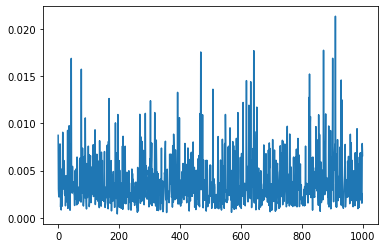

In [7]:
κs = κ_test

# Test projection error
N_trunc, _ = bases.shape
Nx, Ny, N_data = κs.shape
errors = np.zeros(N_data)
base_norms = np.linalg.norm(bases, axis=1)
for i in range(N_data):
    κ = κs[:, :, i].reshape(-1)
    rom_coeffs = np.dot(bases, κ)/base_norms**2
    errors[i] = np.linalg.norm(κ - np.dot(rom_coeffs,bases))/np.linalg.norm(κ)
fig = plt.figure()
plt.plot(errors)


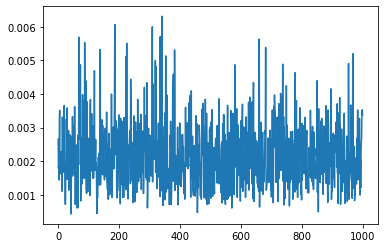

In [8]:
κs = κ_train

# Test projection error
N_trunc, _ = bases.shape
Nx, Ny, N_data = κs.shape
errors = np.zeros(N_data)
base_norms = np.linalg.norm(bases, axis=1)
for i in range(N_data):
    κ = κs[:, :, i].reshape(-1)
    rom_coeffs = np.dot(bases, κ)/base_norms**2
    errors[i] = np.linalg.norm(κ - np.dot(rom_coeffs,bases))/np.linalg.norm(κ)
fig = plt.figure()
plt.plot(errors)

In [7]:
i = 1
κ = κs[:, :, i].reshape(-1)
rom_coeffs = np.dot(bases, κ)/base_norms**2

In [ ]:
rom_coeffs